<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 4
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

### Carga inicial de dependencias y datos

In [157]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
#import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import StandardScaler, MinMaxScaler

##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#Import Keras and Tensor
import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

## Limpieza del dataset

In [158]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()

#Eliminación de columnas irrelevantes
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

#Eliminación de filas con valores nulos
hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

#Eliminación de filas con outliers
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#Agent sin definir es un valor válido, por lo que se reemplaza por Undefined
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
hotels_df_mod['agent'] = hotels_df_mod['agent'].replace('nan', 'Undefined')

#Se crea la columna que dice si se asignó la habitación pedida
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False
hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in hotels_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    hotels_df_mod[col] = scaler.fit_transform(hotels_df_mod[[col]])

#One-hot encoding para las columnas categóricas
hotels_df_mod = pd.get_dummies(hotels_df_mod, columns=["hotel",
    "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type",
    "deposit_type", "customer_type", "agent", 'room_type_match' ], drop_first=True)

hotels_df_mod = hotels_df_mod.reindex(sorted(hotels_df_mod.columns), axis=1)

In [159]:
# Find the columns with data type 'bool'
bool_columns = hotels_df_mod.select_dtypes(include=['bool'])

# Convert the 'bool' columns to 'float64'
for column in bool_columns.columns:
    hotels_df_mod[column] = hotels_df_mod[column].astype('float64')

In [160]:
hotels_df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61681 entries, 0 to 61912
Columns: 499 entries, adults to total_of_special_requests
dtypes: float64(499)
memory usage: 235.3 MB


### Empiezo a crear el modelo

In [161]:
df_x = hotels_df_mod.drop(['is_canceled'], axis=1)
df_y = hotels_df_mod['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, train_size= 0.7, test_size=0.30, random_state=2)

In [162]:
d_in=len(df_x)
# Create a simple feedforward neural network
model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(498,)),  # Input layer
    keras.layers.Dense(8, activation='relu'),  # Hidden layer with 8 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')  # Output layer with 1 unit and sigmoid activation for binary classification
])

model.summary()

Model: "sequential_22"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 8)                 3992      
                                                                 
 dense_67 (Dense)            (None, 8)                 72        
                                                                 
 dense_68 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4073 (15.91 KB)
Trainable params: 4073 (15.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [163]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

cant_epochs=50
# Train the model
history = model.fit(x_train, y_train, epochs=cant_epochs, batch_size=32, validation_split=0.2)

# Evaluate the model on the test dataß
test_loss, test_accuracy, test_auc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/50
1080/1080 [==============================] - 1s 650us/step - loss: 0.4640 - accuracy: 0.7701 - auc: 0.8590 - val_loss: 0.4034 - val_accuracy: 0.8066 - val_auc: 0.8949
Epoch 2/50
1080/1080 [==============================] - 1s 537us/step - loss: 0.3827 - accuracy: 0.8128 - auc: 0.9042 - val_loss: 0.3731 - val_accuracy: 0.8108 - val_auc: 0.9100
Epoch 3/50
1080/1080 [==============================] - 1s 534us/step - loss: 0.3595 - accuracy: 0.8230 - auc: 0.9155 - val_loss: 0.3587 - val_accuracy: 0.8223 - val_auc: 0.9156
Epoch 4/50
1080/1080 [==============================] - 1s 535us/step - loss: 0.3490 - accuracy: 0.8284 - auc: 0.9204 - val_loss: 0.3546 - val_accuracy: 0.8241 - val_auc: 0.9178
Epoch 5/50
1080/1080 [==============================] - 1s 536us/step - loss: 0.3432 - accuracy: 0.8324 - auc: 0.9230 - val_loss: 0.3540 - val_accuracy: 0.8228 - val_auc: 0.9197
Epoch 6/50
1080/1080 [==============================] - 1s 534us/step - loss: 0.3394 - accuracy: 0.8348 - auc:

### Matriz de Confusion y otras métricas

579/579 [==============================] - 0s 263us/step
Matriz de confusión de los datos de prueba


Text(50.722222222222214, 0.5, 'True')

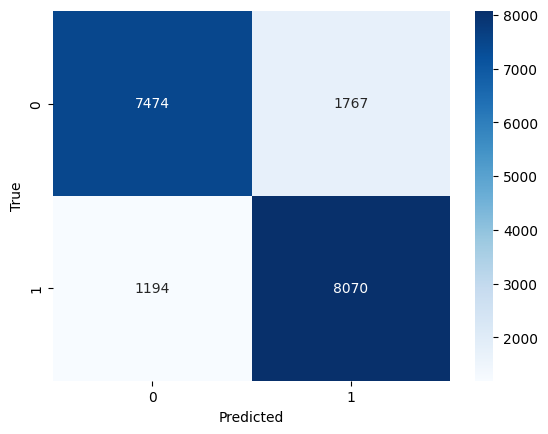

In [164]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

binary_predictions_test = (y_test_pred > 0.5).astype(int)
binary_predictions_train = (y_train_pred > 0.5).astype(int)

print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, binary_predictions)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [165]:
train_score = f1_score(y_train, binary_predictions_train)
test_score = f1_score(y_test, binary_predictions_test)

print("F1-Score sobre el set de entrenamiento:", round(train_score, 3))
print("F1-Score sobre el set de prueba:", round(test_score, 3))

F1-Score sobre el set de entrenamiento: 0.855
F1-Score sobre el set de prueba: 0.84


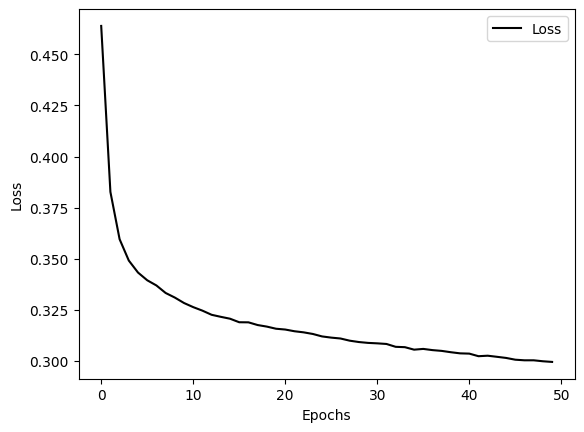

In [166]:
plt.plot(history.history['loss'], color='black', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

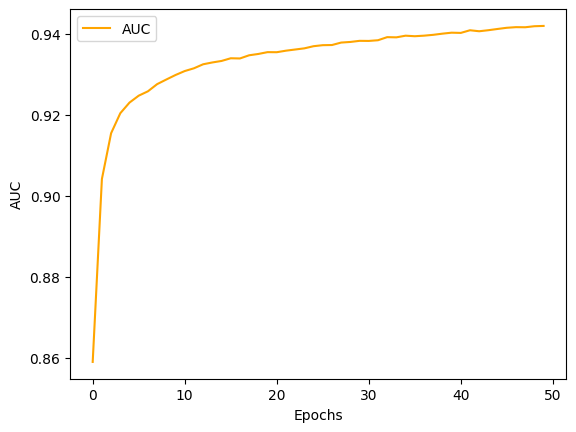

In [167]:
plt.plot(history.history['auc'], color='orange', label='AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

## Predicción de hotels_test

Se modifica el dataset de test de manera similar al de train, para que el modelo obtenido pueda ser aplicado.

In [168]:
test_df = pd.read_csv('hotels_test.csv')
test_df_mod = test_df.copy()

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False
test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)

id_backup = test_df_mod[['id']].copy()

test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns') #Esta es la columna que no debería estar en el dataset de test

#Se normalizan los valores de las columnas numéricas cuantitativas
scaler = MinMaxScaler(feature_range=(0,1))
for col in test_df_mod.select_dtypes(include=[np.number, "int64", "float64"]).columns:
    test_df_mod[col] = scaler.fit_transform(test_df_mod[[col]])

#One-hot encoding para las columnas categóricas
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent", "room_type_match" ], drop_first=True)

#Se crean las columnas que están en el df para entrenar pero no en el df a predecir
for col in df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

/var/folders/sx/p4bbsw2947l2kjgww8lxntch0000gn/T/ipykernel_2982/3312754589.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_mod[col] = False
/var/folders/sx/p4bbsw2947l2kjgww8lxntch0000gn/T/ipykernel_2982/3312754589.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_mod[col] = False
/var/folders/sx/p4bbsw2947l2kjgww8lxntch0000gn/T/ipykernel_2982/3312754589.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance. 

In [169]:
# Find the columns with data type 'bool'
bool_columns = test_df_mod.select_dtypes(include=['bool'])

# Convert the 'bool' columns to 'float64'
for column in bool_columns.columns:
    test_df_mod[column] = test_df_mod[column].astype('float64')

In [170]:
#Se realiza una predicción sobre test utilizando el modelo
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred.astype(int)

predictions.to_csv('sample_submission.csv', index=False)

830/830 [==============================] - 0s 275us/step
